# Customer segmentation for targeted marketing campaigns

The available dataset contains the following information:

 - **CUST_ID** : Unique identifier of the cardholder (categorical).
 - **BALANCE** : Amount of balance remaining in the account for purchases.
 - **BALANCE_FREQUENCY** : Frequency of balance updates, with a score between 0 and 1 (1 = updated frequently, 0 = not updated frequently).
 - **PURCHASES** : Total amount of purchases made from the account.
 - **ONEOFF_PURCHASES** : Maximum amount of purchases made in one go.
 - **INSTALLMENTS_PURCHASES** : Amount of purchases made in installments.
 - **CASH_ADVANCE** : Cash advance given by the user.
 - **PURCHASES_FREQUENCY** : Frequency of purchases, with a score between 0 and 1 (1 = frequent purchases, 0 = infrequent purchases).
 - **ONEOFF_PURCHASES_FREQUENCY** :  Frequency with which one-time purchases are made (1 = frequent, 0 = infrequent).
 - **PURCHASES_INSTALLMENTS_FREQUENCY** : Frequency with which installment purchases are made (1 = frequent, 0 = infrequent).
 - **CASH_ADVANCE_FREQUENCY** : Frequency with which cash advance is requested.
 - **CASH_ADVANCE_TRX** : Number of transactions made with cash advance.
 - **PURCHASES_TRX** : Total number of purchase transactions made.
 - **CREDIT_LIMIT** : Maximum credit card limit for each user.
 - **PAYMENTS**  : Total amount of payments made by the user.
 - **MINIMUM_PAYMENTS** : Minimum amount of payments made by the user.
 - **PRCFULLPAYMENT** : Percentage of the full payment paid by the user.
 - **TENURE** : Duration of credit card service for the user (in years).

**GOAL** : The main objective is to develop a customer segmentation model based on information provided by the company's dataset containing data from a variety of credit card holders. The segmentation will help the company identify specific clusters toward which to target marketing strategies.

### [Link al dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_card_customers.csv)

## Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import linregress, ks_1samp, norm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from scipy.stats import skewtest, skew
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.cluster import KMeans
from kneed import KneeLocator

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV

## Functions

In [180]:
def plot_features_distribution(df, subplot_cols=5):
    '''
    Take in input a df and the subplot cols
    Plot the distribution of the features in the df
    Show the mean, the median and the skewness of the distribution
    '''
    subplot_rows = math.ceil(len(df.columns)/subplot_cols)
    fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 20))
    axes = axes.flatten()
    
    for i, col in enumerate(df.columns):
        axes[i].hist(df[col], bins="rice", color='b', edgecolor ='black' ,alpha=0.7)
        axes[i].axvline(df[col].mean(), color='red', linestyle='-')
        axes[i].axvline(df[col].median(), color='g', linestyle='-')
        axes[i].set_title(col)
        skw = df[col].skew()
        axes[i].legend(['mean', 'median', 'skewness: {:.2f}'.format(skw)], loc='upper right')

In [181]:
def get_high_corr_var(corr_matrix, threshold=0.8):
    '''
    Return the tuples of variables that are highly correlated
    Correlation over the threshold are considered highly correlated
    The threshold is set to 0.8 by default
    '''
    corr_var = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                colname = corr_matrix.columns[i]
                rowname = corr_matrix.columns[j]
                corr_var.append((colname, rowname))
    return corr_var

In [182]:
def skew_test_to_df(X, features_names=None):
    '''
    Return a df with name of features (if given in input), skewness and p-value of the skewness test
    Input : dataset array like, features_names list like
    '''
    skew_values = skew(X)
    p_values = skewtest(X).pvalue
    
    if features_names is None:
        features_names = ['Feature {}'.format(i) for i in range(X.shape[1])]
        
    skew_df = pd.DataFrame({'Variable': features_names, 'Skewness': skew_values, "p value" : p_values})
    
    return skew_df

In [183]:
def select_best_k(X, 
                k_max=10,
                plot=True):
    '''
    Return the best number of clusters according to the metrics,
    Plot the metrics if plot is set to True (default), 
    highlighting the best number of clusters with red points and lines
    Input:  dataset X array like,
            k_max int, 
            plot bool
    '''
    clusters = range(2, k_max+1)
    sil_scores = []
    dav_boul_scores = []
    inertia_scores = []

    for n in clusters:
        cluster = KMeans(init="k-means++", n_clusters = n, random_state=0)
        pred = cluster.fit_predict(X)
        
        s_score = silhouette_score(X, pred)
        sil_scores.append(s_score)
        
        db_score = davies_bouldin_score(X, pred)
        dav_boul_scores.append(db_score)
        
        in_score = cluster.inertia_
        inertia_scores.append(in_score)
        
        
    if plot:
        fig, ax = plt.subplots(1, 3, figsize=(20, 5))
        max_silhouette_indices = np.argsort(sil_scores)[-2:]
        min_db_indices = np.argsort(dav_boul_scores)[:2]

        ax[0].plot(clusters, sil_scores, 'bo-')
        ax[0].set_title('Silhouette Score')
        ax[0].set_xlabel('Number of clusters')
        ax[0].set_ylabel('Silhouette Score')
        ax[0].scatter(np.array(clusters)[max_silhouette_indices], 
               np.array(sil_scores)[max_silhouette_indices], 
               color='red', zorder=5)
        for index in max_silhouette_indices:
            ax[0].axvline(x=clusters[index], color='r', linestyle='--')
        
        ax[1].plot(clusters, dav_boul_scores, 'bo-')
        ax[1].set_title('Davies Bouldin Index')
        ax[1].set_xlabel('Number of clusters')
        ax[1].set_ylabel('Davies Bouldin Score')
        ax[1].scatter(np.array(clusters)[min_db_indices], 
               np.array(dav_boul_scores)[min_db_indices], 
               color='red', zorder=5)
        for index in min_db_indices:
            ax[1].axvline(x=clusters[index], color='r', linestyle='--')
        
        kl = KneeLocator(clusters, inertia_scores, curve="convex", direction="decreasing")
        ax[2].plot(clusters, inertia_scores, 'bo-')
        ax[2].set_title('Elbow Method')
        ax[2].set_xlabel('Number of clusters')
        ax[2].set_ylabel('SSD')
        if kl.elbow is not None: 
            ax[2].axvline(x=kl.elbow, color='r', linestyle='--', label='Elbow')
            ax[2].scatter(kl.elbow, inertia_scores[kl.elbow - 2], color='red', zorder=5)

        plt.tight_layout()
        plt.show()
        
    best_sil_score = clusters[np.argmax(sil_scores)]
    best_dav_boul_score = clusters[np.argmin(dav_boul_scores)]
    best_elbow_method = kl.elbow
    
    return best_sil_score, best_dav_boul_score, best_elbow_method

In [262]:
def boxplot_by_feature(df, feature, feature_to_group):
    '''
    Take a df as input and group by for a column
    Filter the df for the feature 
    Calculate the values for boxplot with aggregate
    Show the boxplot with the mean for every category grouped and the bar of the mean alongside
    '''
    
    plt.figure(figsize=(6, 4))
    ax = sns.boxplot(x=feature_to_group, y=feature, data=df, width=0.4, showfliers=False)  # Boxplot without outlier

    means = pd.DataFrame(df.groupby(feature_to_group)[feature].mean())
    categories = df[feature_to_group].unique()
    x_positions = np.arange(len(categories))  # Indici per i gruppi

    # Aggiunta della colonna della media accanto ai boxplot (spostata a destra)
    bar_separation = 0.4  # Larghezza della barra per la media
    plt.bar(x_positions + bar_separation, means[feature], color='red', width=0.15, label='Mean')

    # Etichette e legenda
    plt.legend()
    plt.title(f"Boxplot of {feature}")
    plt.show()

## Load Dataset

In [185]:
DATASET_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_card_customers.csv"
df = pd.read_csv(DATASET_URL)
df.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


# EDA

## Overview

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

<Axes: >

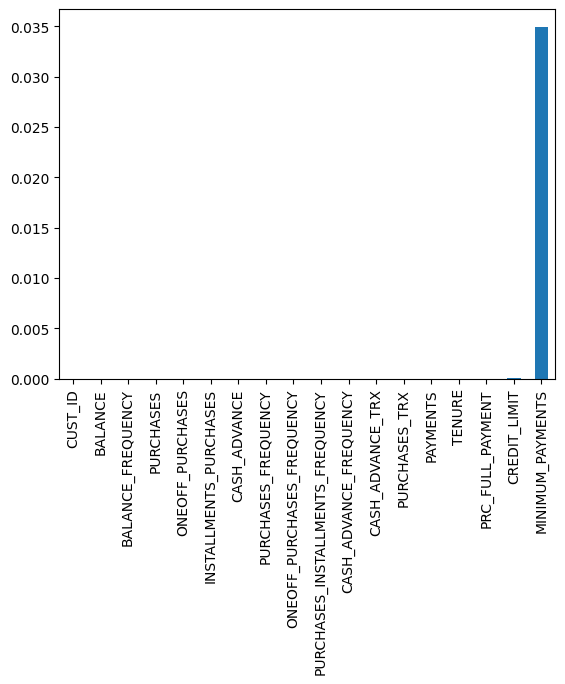

In [188]:
(df.isna().sum()/df.shape[0]).sort_values().plot(kind='bar')

🔔 Only CUST_ID is an object dtype, and isn't useful for the segmentation. 

MINIMUM_PAYMENTS (3,5%) and CREDIT_LIMIT have some Missing Values to impute in the pre-processing.

In [189]:
df = df.drop(columns=["CUST_ID"])
name_features = list(df.columns)

## Univariate Analysis

In [190]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


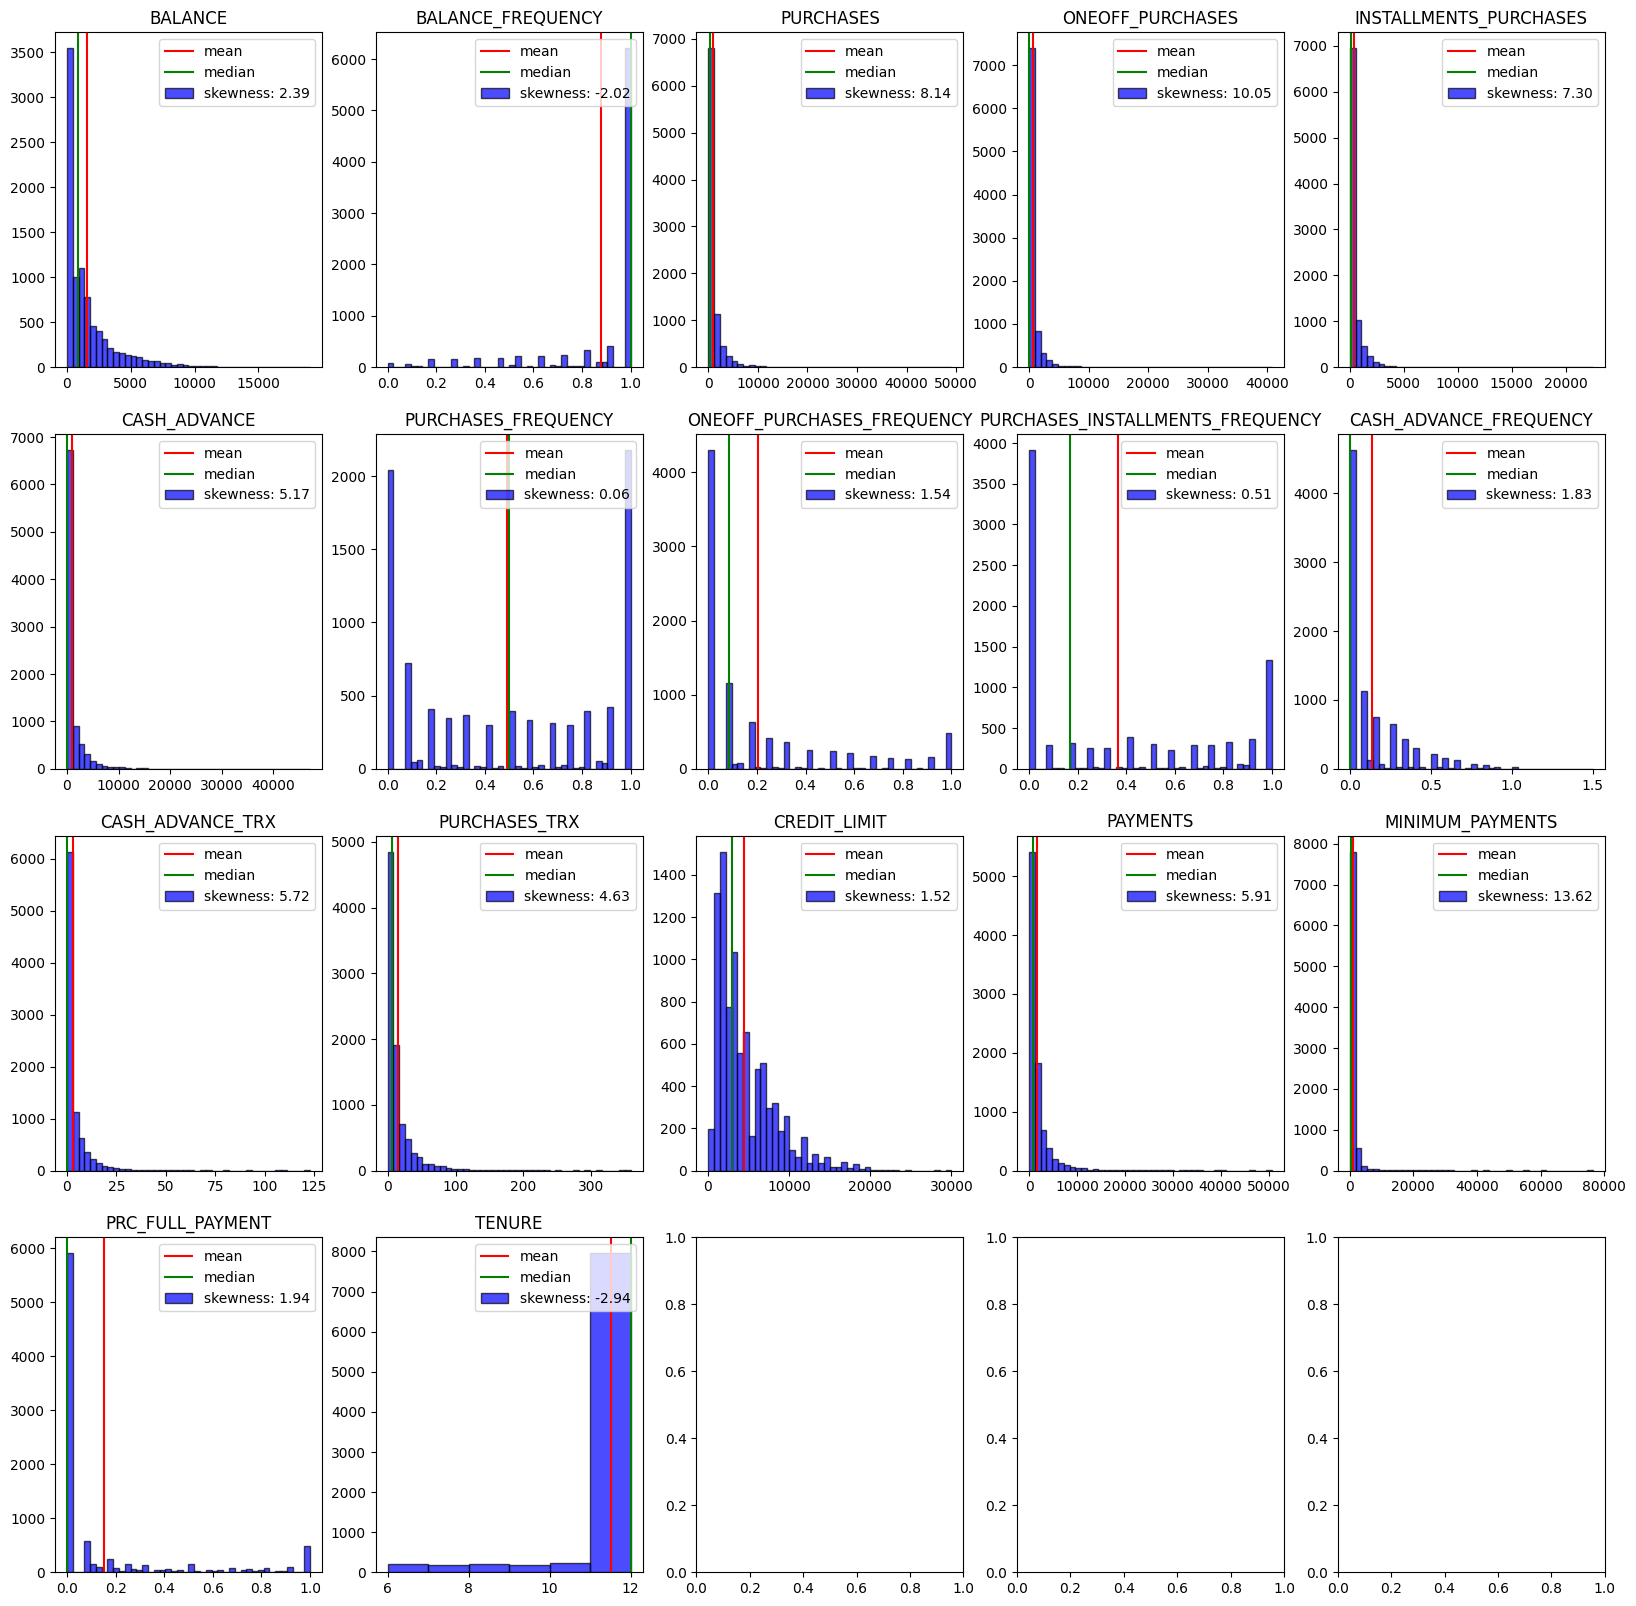

In [191]:
plot_features_distribution(df)

🔔 SYMMETRY DESCRIPTION: 
- Most of the variables distribution are skewed, except PURCHASES_FREQUENCY and PURCHASES_INSTALLMENT_FREQUENCY with skewness almost zero. 
- BALANCE_FREQUENCY and TENURE are negatively (left) skewed, while all the others variables are positvely (right) skewed.

## Multivariate Analysis

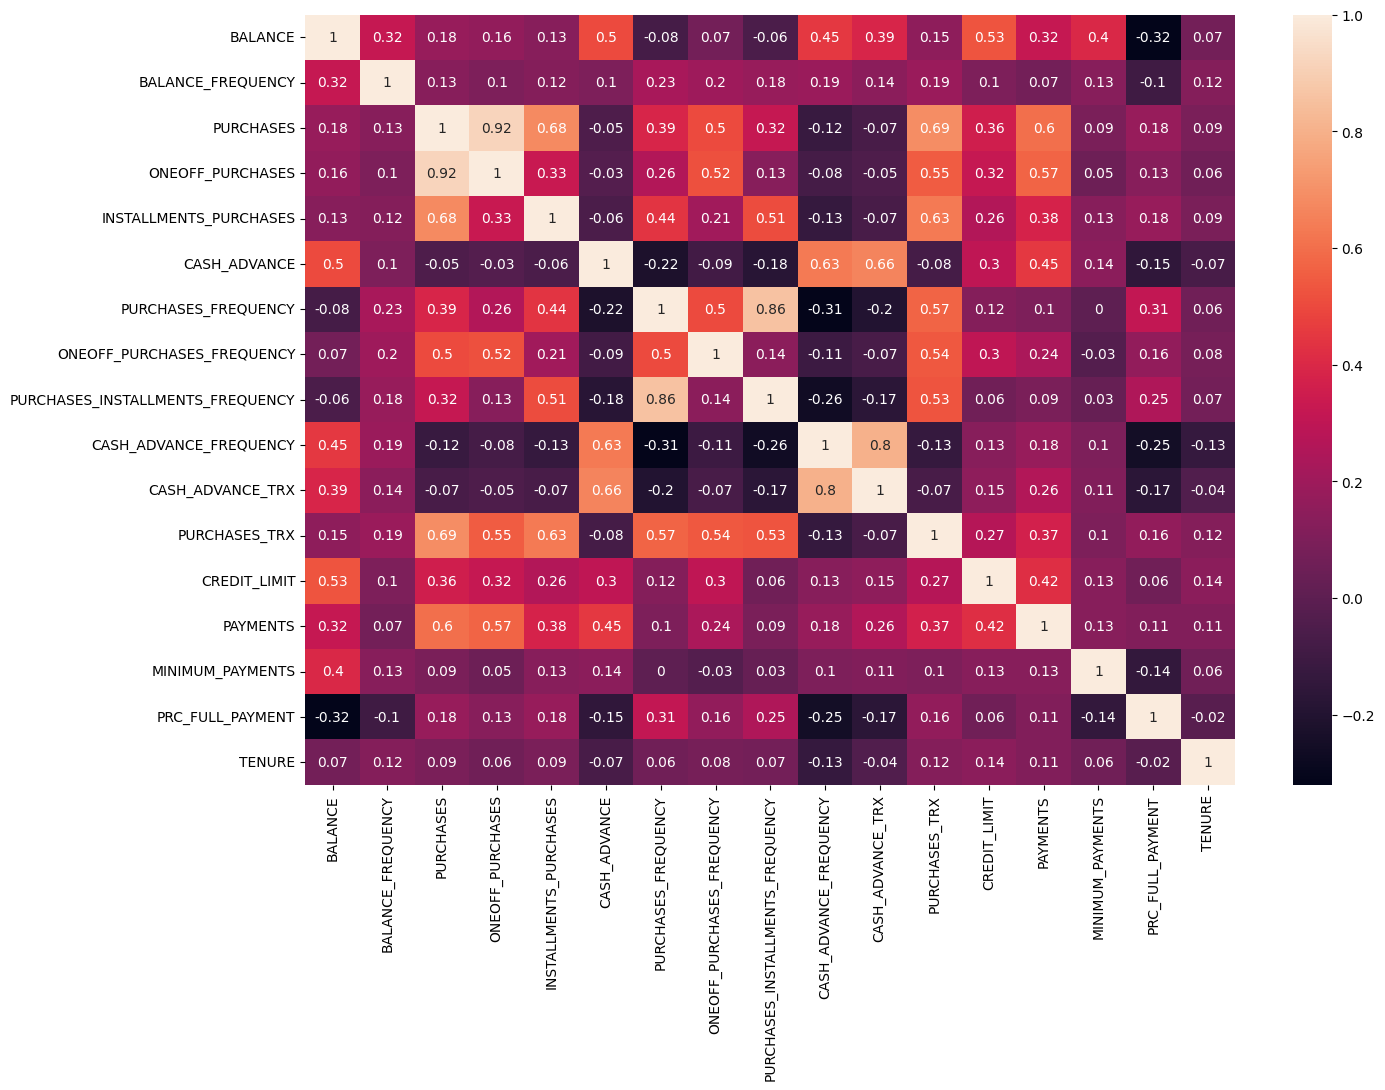

In [192]:
# heat map of the correlation matrix
corr_matrix = round(df.corr(), 2)
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)  
plt.show()

🔔  CORRELATION INSIGHT:
- ONEOFF_PURHCASES with PURCHASES -> corr = 0.92
- PURCHASES_INSTALLMENTS_FREQUENCIES with PURCHASES_FREQUENCIES -> corr = 0.86
- CASH_ADVANCE_TRX with CASH_ADVANCE_FREQUENCIES -> corr = 0.80

Show scatterplot just of these highly correlated variables, to see their behavior

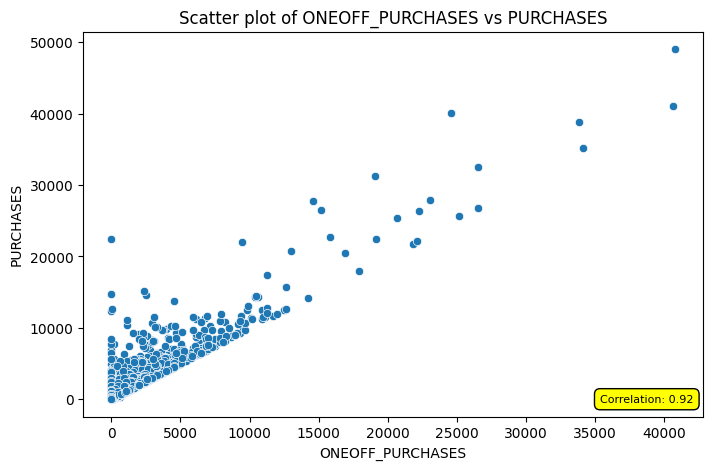

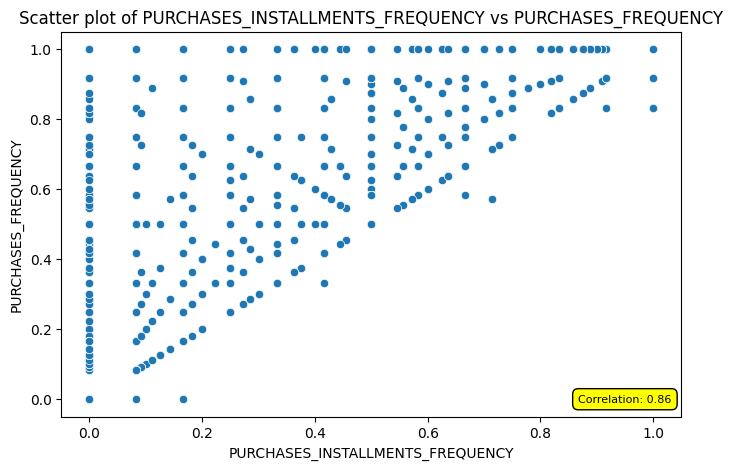

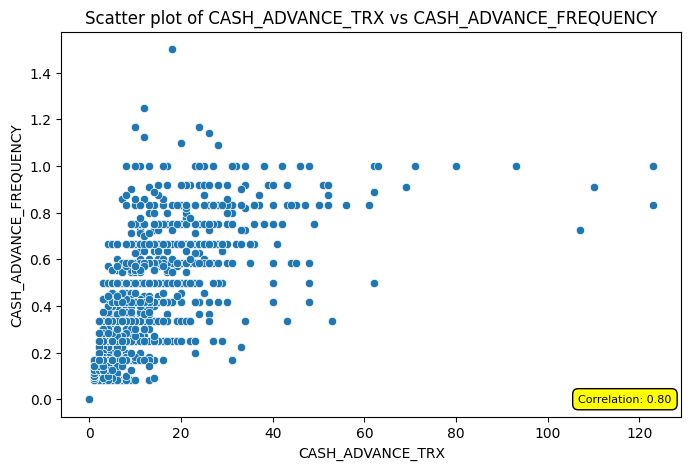

In [193]:
corr_var = get_high_corr_var(corr_matrix, threshold=0.8)

for var in corr_var:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=var[0], y=var[1], data=df)
    plt.title('Scatter plot of {} vs {}'.format(var[0], var[1]))
    plt.text((df[var[0]].max()-0.05*df[var[0]].max()), df[var[1]].min(), 
             'Correlation: {:.2f}'.format(corr_matrix.loc[var[0], var[1]]),
             fontsize=8,
             ha='center',
             va='center',
             bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'))
    plt.show()

In [194]:
# test the log relation
x = df["CASH_ADVANCE_TRX"]
y = df["CASH_ADVANCE_FREQUENCY"]
log_x = np.log(x+1)
slope, intercept, r_value, p_value, std_err = linregress(log_x, y)
print(f"R-quadro: {r_value**2:.4f}")


R-quadro: 0.8327


In [195]:
# number of values over 1 in CASH_ADVANCE_FREQUENCY 
limit = 1
count = len([a for a in y if a > limit])
print(count)

8


🔔  CORRELATION INSIGHT:
- *ONEOFF_PURHCASES with PURCHASES* -> increasing the maximum in one off purchases increase the quantity of purchases (included the installments) too, stictly high correlation;

- *PURCHASES_INSTALLMENTS_FREQUENCIES with PURCHASES_FREQUENCIES* -> constrained relation due to data structure, every installment purchase is a purchase so PURCHASES_INSTALLMENTS_FREQUENCIES $ \leq$ PURCHASES_FREQUENCIES (diagonal). When the purchase is done one off then the PURCHASES_INSTALLMENTS_FREQUENCIES is 0 and PURCHASES_FREQUENCIES can assume all the values between 0 and 1 (left side of the triangle).

- *CASH_ADVANCE_TRX with CASH_ADVANCE_FREQUENCIES* -> even in this case it's shown a logic relation due to the variable definition about the cash advance, so higher is the frequency of cash advance ask greater will be the cash advance transaction number. From the scatter plot and R2 (83% from linear regression between log(cash_advace_trx) and cash_advace_frequency) seems exist a logaritmic relation. Some of the CASH_ADVACE_FREQUENCY seems to be out of range (8 values over limit 1), points losing of meaning.

# Pre-Processing

## Missing values

In [196]:
ks_1samp(df['CREDIT_LIMIT'], norm.cdf, nan_policy = 'omit')

KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(50.0), statistic_sign=np.int8(-1))

In [197]:
ks_1samp(df['MINIMUM_PAYMENTS'], norm.cdf, nan_policy = 'omit')

KstestResult(statistic=np.float64(0.9981411013641146), pvalue=np.float64(0.0), statistic_location=np.float64(4.363375), statistic_sign=np.int8(-1))

🔔 From the histogram of the CREDIT_LIMIT and MINIMUM_PAYMENTS distributions (seen in the EDA) we can see the non normal behavior, and the Kolmogorov-Smirnov test confirmed that (pvalues very low). So we will impute the missing values with the median value of each distribution.

In [198]:
imputer = SimpleImputer(strategy = 'median')
X_imputed = imputer.fit_transform(df)

## Scaling

In [199]:
scaler = StandardScaler()
X_1 = scaler.fit_transform(X_imputed)

## Power Transformation

In [200]:
power = PowerTransformer(method='yeo-johnson')
X_2 = power.fit_transform(X_1)

🔔 As we saw in the EDA almost every feature is skewed, so we applied a Power Transformation to reduce the asimmetry even in the resulted components of PCA.

## PCA

In [201]:
pca = PCA()
pca.fit(X_2)

PCA()

<BarContainer object of 17 artists>

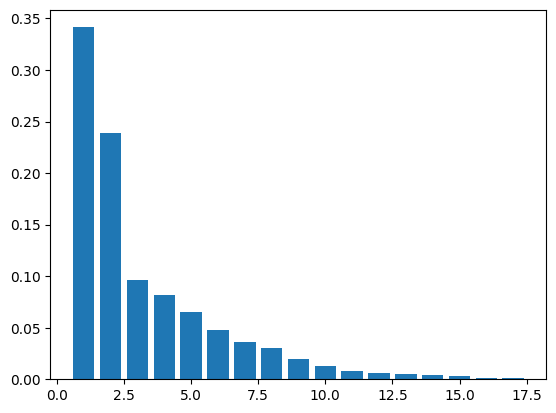

In [202]:
x = range(1,df.shape[1]+1)
y = pca.explained_variance_ratio_
plt.bar(x,y)

In [203]:
np.cumsum(pca.explained_variance_ratio_)

array([0.34141079, 0.58005746, 0.67644923, 0.75776189, 0.82266117,
       0.87085994, 0.90666293, 0.93746569, 0.956679  , 0.96980092,
       0.9776226 , 0.98394015, 0.98953865, 0.99401972, 0.99733657,
       0.99902833, 1.        ])

🔔 The cumulative variance has the max drop after the second component but it's not enought 58%. 

With the consideration of 5 PCs is explained 82% of the variance of the features, while with 7 PCs is explained 90% of the variance.

We're going to consider the 2 situation in the choice of the number of clusters.

In [236]:
pca_5 = PCA(n_components=5)
X_pc5 = pca_5.fit_transform(X_2)

In [237]:
np.abs(skew(X_pc5))

array([0.05629142, 0.36302323, 0.10148059, 0.16971756, 0.7160324 ])

In [238]:
skewtest(X_pc5).pvalue

array([2.96904720e-002, 3.59099774e-042, 9.12824334e-005, 7.31272414e-011,
       7.78147008e-138])

In [239]:
pca_7 = PCA(n_components=7)
X_pc7 = pca_7.fit_transform(X_2)
np.abs(skew(X_pc7))

array([0.05629142, 0.36302323, 0.10148059, 0.16971756, 0.7160324 ,
       0.12327916, 0.10505327])

In [240]:
skewtest(X_pc7).pvalue

array([2.96904720e-002, 3.59099774e-042, 9.12824334e-005, 7.31272414e-011,
       7.78147008e-138, 2.06043631e-006, 5.12882684e-005])

🔔 Checking the skewness of the principal components we can see moderate values even if the simmetry is rejected from the hypothesis test. Clustering methods as KMeans doen't need the assumption of normality of the data so we go ahead in the analysis.

In [241]:
X_pc5 = StandardScaler().fit_transform(X_pc5)
X_pc7 = StandardScaler().fit_transform(X_pc7)

# Clustering

## K-means

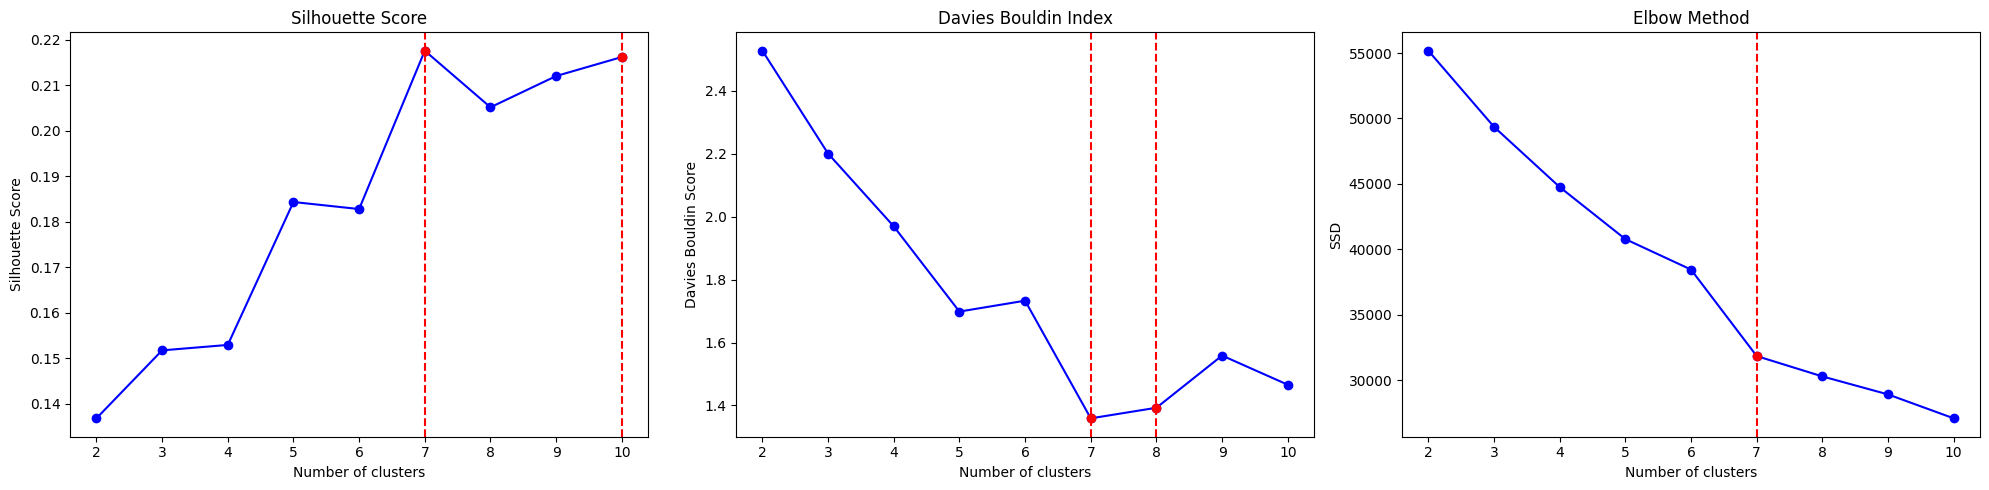

In [ ]:
select_best_k(X_pc7, k_max=10)

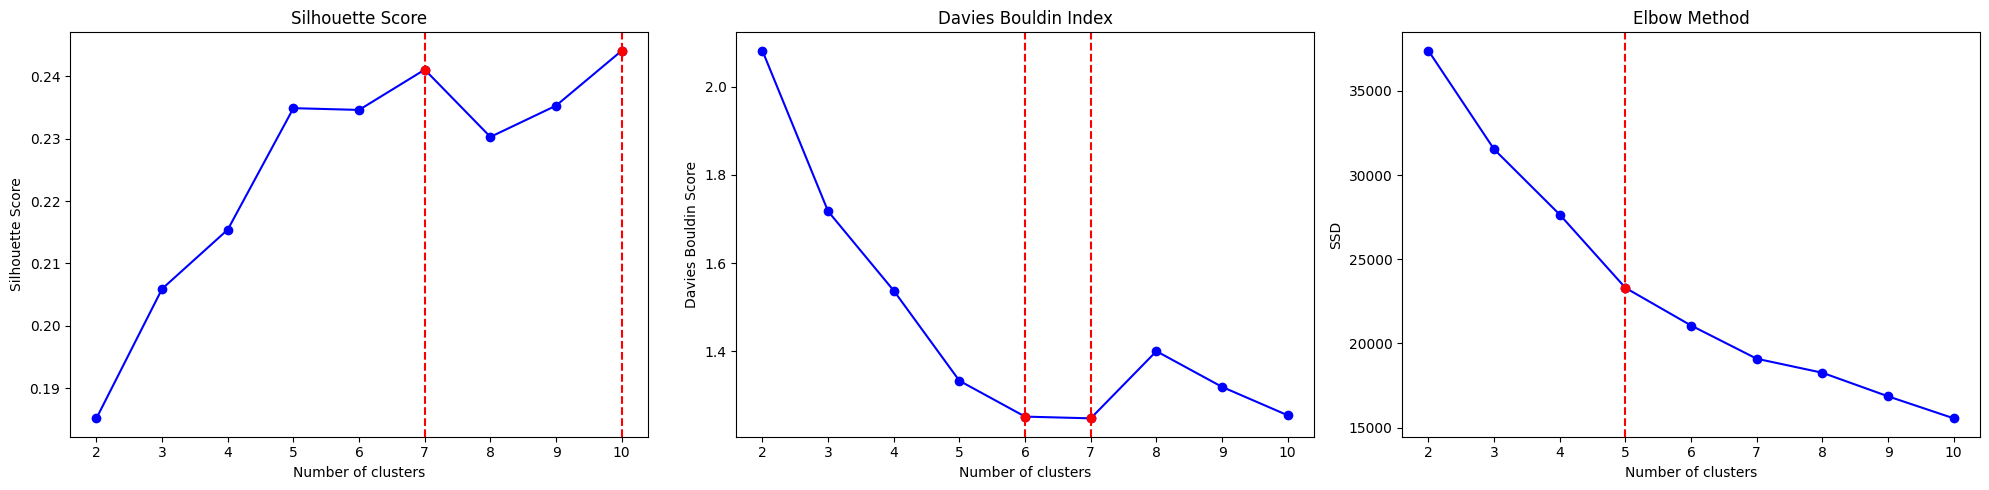

In [ ]:
select_best_k(X_pc5, k_max=10)

🔔 With 7 PCs (90% explained variance) the K best selection methods identified 7 cluster as the best model, which is more difficult to handle from the perspective of describing clusters and drawing conclusions. 

With 5 PCs (and consequently have an explained variance around 82%) the K best selection criterias gave better results (5 cluster) and from the perspective of the segmentation fewer clusters means a more feasible analysis (gain simplicity in explainations of the results losing 8% of variance).

So the choice is to use 5 principal components and 5 clusters.



In [246]:
# create pipeline of pre processing and apply it
pre_processing_pipe = make_pipeline(scaler, power, pca_5, StandardScaler())
X = pre_processing_pipe.fit_transform(X_imputed)

# create the clustering model and fit
k_means = KMeans(n_clusters = 5, random_state=0, n_init=10)
pred = k_means.fit_predict(X)

In [247]:
k_means.cluster_centers_

array([[ 1.17243563,  0.92849047,  0.45552953,  0.12336901, -0.04835029],
       [-1.15529492,  0.63382352, -0.15512048,  0.2020496 ,  0.61091055],
       [ 0.59030677, -0.63944582, -1.08615192,  0.04278561,  0.40581768],
       [-0.20630379, -0.54266921,  0.74178731, -0.86507964,  0.17772629],
       [-0.42629742, -0.42276006,  0.08619669,  0.83753533, -1.78928019]])

In [248]:
pre_processing_pipe.inverse_transform(k_means.cluster_centers_)

array([[1.35196558e+03, 9.88701337e-01, 2.14772858e+03, 9.87617228e+02,
        4.59880569e+02, 2.90030030e+02, 9.04948008e-01, 4.61075663e-01,
        5.37782969e-01, 4.84338198e-02, 9.74207780e-01, 2.88982263e+01,
        6.08985120e+03, 2.25645450e+03, 5.47155409e+02, 6.90694046e-02,
        1.19796853e+01],
       [2.01913590e+03, 9.74877300e-01, 1.00314955e+02, 3.71287802e+01,
        3.58447143e+01, 1.34079334e+03, 9.63835402e-02, 2.06495661e-02,
        4.98775086e-02, 2.48052969e-01, 4.63625570e+00, 1.42522183e+00,
        4.51475093e+03, 1.37387223e+03, 7.45015694e+02, 2.03595975e-02,
        1.19800105e+01],
       [4.06413501e+02, 9.65936912e-01, 5.13314547e+02, 3.58486878e+01,
        4.60206118e+02, 5.27413672e+01, 7.59767489e-01, 2.47799647e-02,
        7.36830339e-01, 1.28468910e-02, 2.25840750e-01, 1.20638845e+01,
        2.78905080e+03, 7.72676720e+02, 2.88602223e+02, 9.38712190e-02,
        1.19904442e+01],
       [6.92496382e+02, 9.56754888e-01, 3.15822417e+02, 2.386

In [249]:
df = pd.DataFrame(X_imputed, columns=name_features)
df['label'] = pred

In [250]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,label
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0,3
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0,1
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0,3
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,312.343947,0.000000,12.0,3
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0,3


🔔 After predicting the clusters and calculated the centroids was performed the inverse transformation on every step of the pipeline to have the clusters in the original data coordinates. Then was created the df with every record labeled according its cluster membership.

### Supervised model 
Try to explain the clusters and the importance of the features with a classification model.

We're going to use a Random Forest Classifier because the algorithm return the importance of every feature in the classifing prediction.

In [216]:
y = pred
X = df.drop(columns=["label"])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [217]:
model = RandomForestClassifier(random_state = 0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [218]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       538
           1       0.95      0.94      0.94       570
           2       0.94      0.96      0.95       607
           3       0.94      0.92      0.93       633
           4       0.94      0.93      0.94       337

    accuracy                           0.94      2685
   macro avg       0.94      0.94      0.94      2685
weighted avg       0.94      0.94      0.94      2685



<Axes: title={'center': 'Features importance'}>

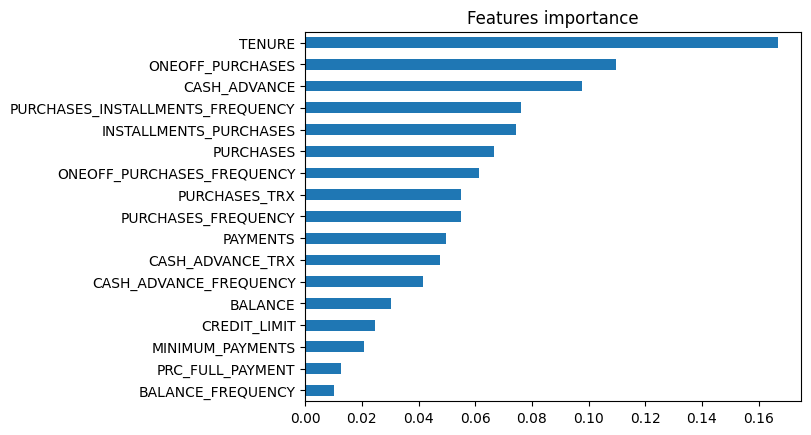

In [219]:
pd.Series(model.feature_importances_,index=X.columns).sort_values().plot(kind='barh', title='Features importance')

In [220]:
imp_sort = sorted(model.feature_importances_, reverse=True)
sum(imp_sort[0:3])

np.float64(0.37415360399882075)

🔔 The supervised model has good performances (94% of accuracy), now with the **Recursive Feature Elimination** we are going to find the features that mostly help the model in classifing the clusters.

In [ ]:
rfe = RFECV(RandomForestClassifier(random_state = 0),scoring='balanced_accuracy',cv=5)
rfe.fit(X_train,y_train)

In [ ]:
rfe.get_feature_names_out()

In [ ]:
rfe.ranking_

In [ ]:
rfe.support_

🔔 From the **RFE** we can't get a lot of information about the features importance because it rules out only the *PURCHASES* feature.

On the other hand from **feature_importances_** of the random forest model we can observ the relative importance of every variable in the classifing process. It shows that *TENURE*, *ONEOFF_PURHCASES*, *PURCHASES_INSTALLMENTS_FREQUENCY* and *INSTALLMENTS_PURCHASES* are the most important feature to disciminate in the classification into a cluster or in another.

## Description of the clusters

Description of:
- average expenses (balance, one off purchases, installment purchases)
- payments habits (% of minimum payments, complete payments)
- usage frequency (cash advance, purchases frequency)

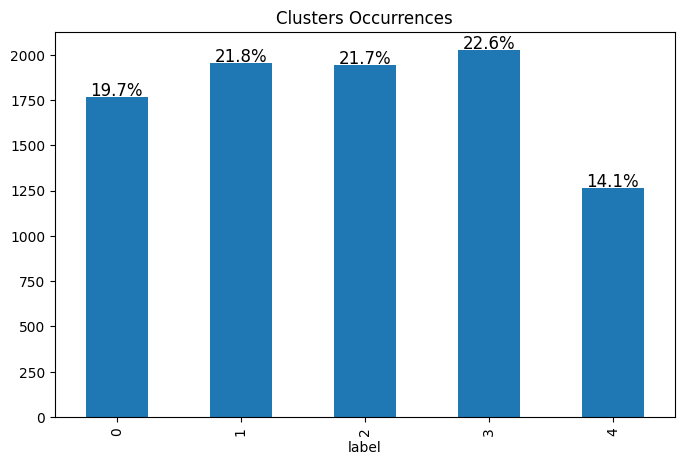

In [256]:
counts = df['label'].value_counts()
counts = counts.sort_index()
percentages = counts / counts.sum() * 100
ax = counts.plot(kind='bar', title='Clusters Occurrences', figsize=(8,5))

# Add percentage labels
for i, (count, perc) in enumerate(zip(counts, percentages)):
    ax.text(i, count + 10, f'{perc:.1f}%', ha='center', fontsize=12)

plt.show()

🔔 The clusters are approximately well balanced.

In [257]:
# some useful KPI
df['year_avg_PURCHASE']=df['PURCHASES']/df['TENURE']
df['CASH_ADVANCE_per_year']=df['CASH_ADVANCE']/df['TENURE']
df['Limit_usage']=df['BALANCE']/df['CREDIT_LIMIT']
df['PAYMENT_MINPAY_ratio']=df['PAYMENTS']/df['MINIMUM_PAYMENTS']

In [ ]:
display(df.groupby('label').aggregate(['mean']).transpose().round(2))

,label,0,1,2,3,4
BALANCE,mean,2271.98,3002.37,586.41,874.03,962.55
BALANCE_FREQUENCY,mean,0.97,0.93,0.86,0.81,0.80
PURCHASES,mean,3342.21,115.38,716.09,440.86,453.74
ONEOFF_PURCHASES,mean,2244.95,58.83,36.87,397.23,278.25
INSTALLMENTS_PURCHASES,mean,1097.26,56.61,680.14,43.85,175.77
CASH_ADVANCE,mean,887.16,2743.81,107.87,93.23,1135.73
PURCHASES_FREQUENCY,mean,0.88,0.11,0.80,0.27,0.42
ONEOFF_PURCHASES_FREQUENCY,mean,0.61,0.03,0.03,0.21,0.14
PURCHASES_INSTALLMENTS_FREQUENCY,mean,0.65,0.07,0.76,0.07,0.28
CASH_ADVANCE_FREQUENCY,mean,0.11,0.33,0.02,0.04,0.20


### Average Expences

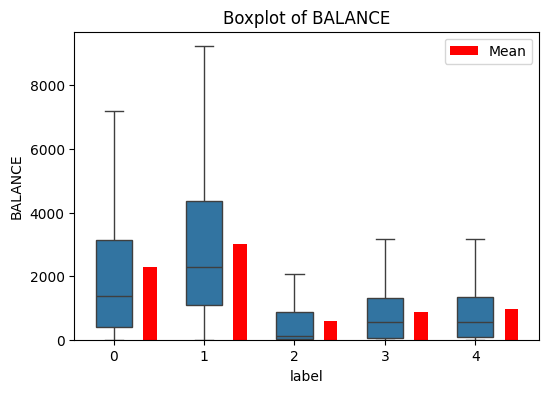

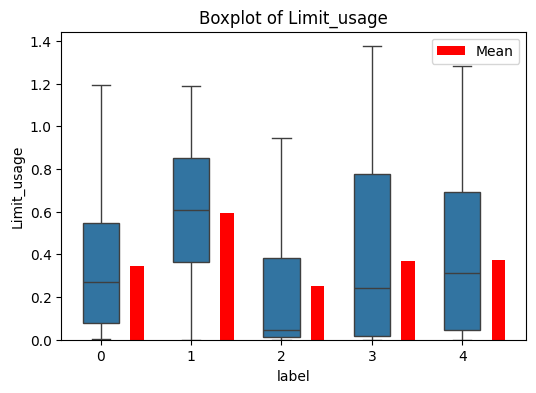

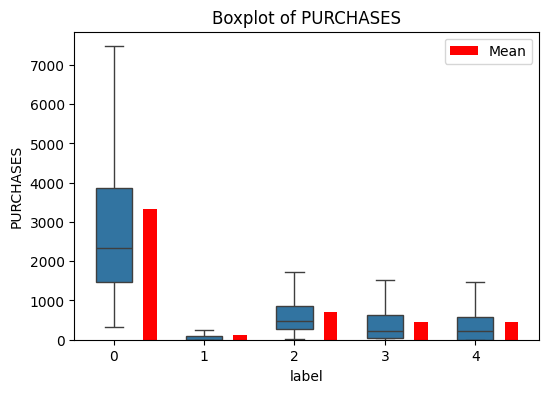

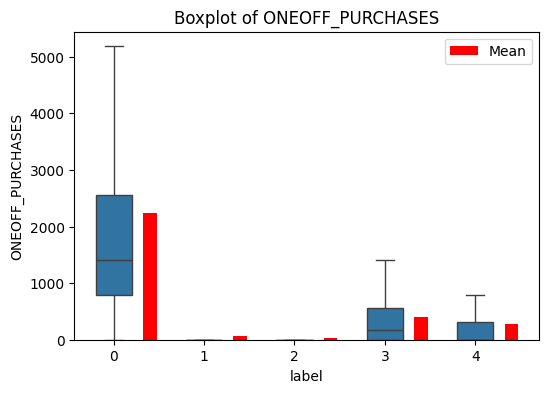

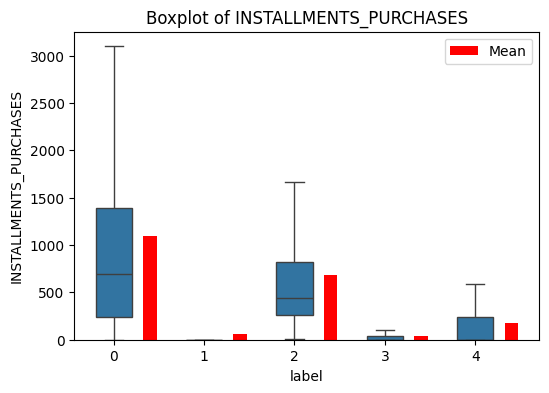

In [263]:
boxplot_by_feature(df=df, feature='BALANCE', feature_to_group='label')
boxplot_by_feature(df=df, feature='Limit_usage', feature_to_group='label')
boxplot_by_feature(df=df, feature='PURCHASES', feature_to_group='label')
boxplot_by_feature(df=df, feature='ONEOFF_PURCHASES', feature_to_group='label')
boxplot_by_feature(df=df, feature='INSTALLMENTS_PURCHASES', feature_to_group='label')

🔔 On the expences side we can indentify some main specifications of the clusters.
- Cluster 0 spends more in every type of purchase (installments or one off), there's a great distinction with the others, high balance.
- Cluster 1 is the cheapest on purchases having the highest balance.
- Clusters 2,3 and 4 have in common a low spending habit and low balance, but the cluster 2 tends to buy more in installments than the 1,2,4. 

About limit usage is moderate in all the cluster except for the cluster 1 that is high indicating a possible presense of credit risk.

### Payment Habits

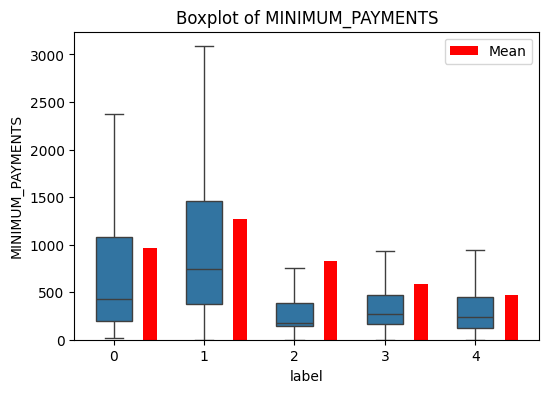

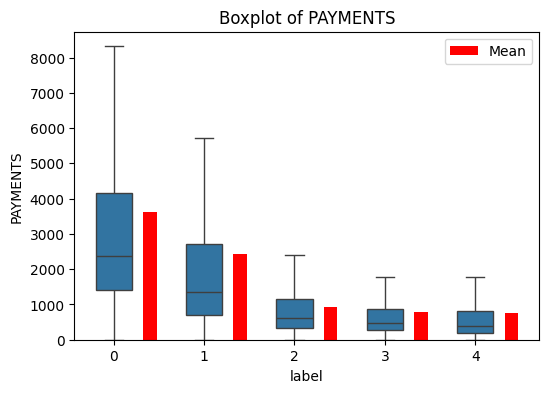

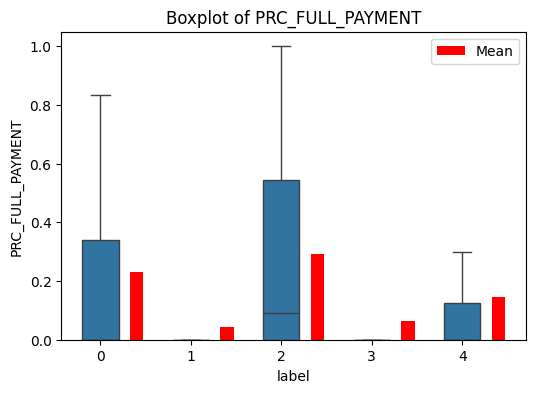

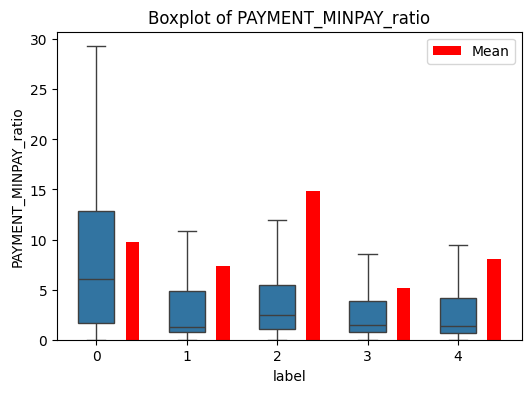

In [264]:
boxplot_by_feature(df=df, feature='MINIMUM_PAYMENTS', feature_to_group='label')
boxplot_by_feature(df=df, feature='PAYMENTS', feature_to_group='label')
boxplot_by_feature(df=df, feature='PRC_FULL_PAYMENT', feature_to_group='label')
boxplot_by_feature(df=df, feature='PAYMENT_MINPAY_ratio', feature_to_group='label')

🔔 On the payments behaviors we can recognize:
- Clusters 0 and 1 have distributions (and means) of payments shifted up compared to clusters 2,3,4. This tendency is seen even on the minimum payments.
- Clusters 1 and 3 have level of full payments percentage very low while clusters 0 and 2 have a good level of full payment.

About the ratio on payments-minimum payments:
- Clusters 0,1,2 are reliable customers, less prone to late payments (they pay 9,7 and 14 times the minimum required).
- Cluster 4 has a moderate ratio, indicating balanced debt management.
- Cluster 3 the lowest value, Indicating that these users could pay only the necessary.

### Usage Frequency

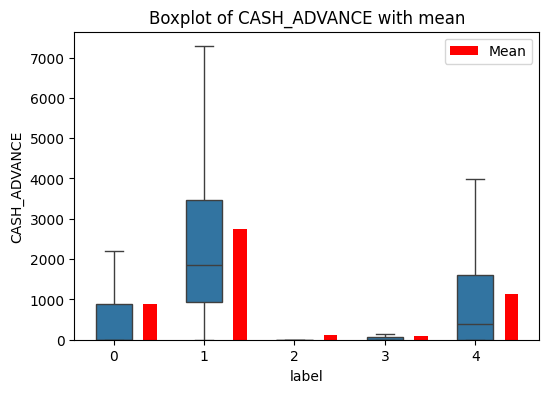

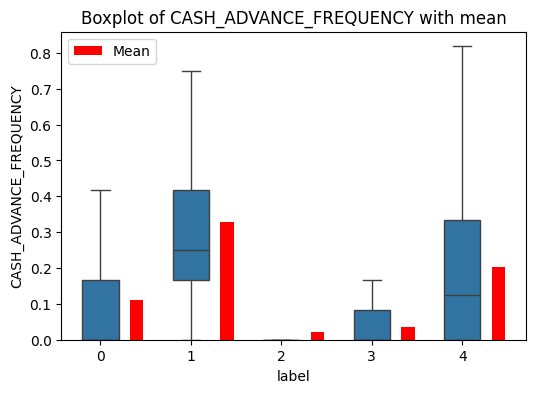

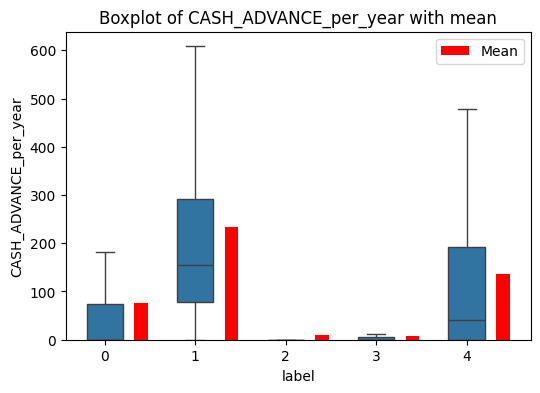

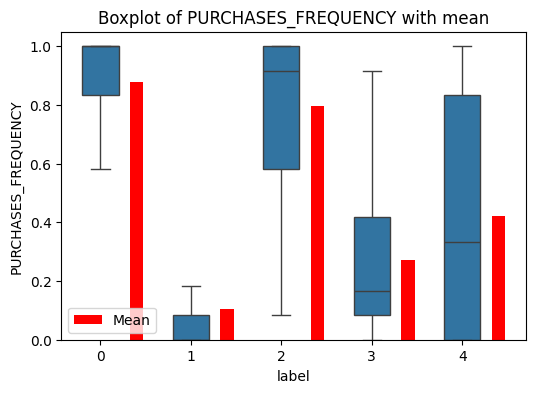

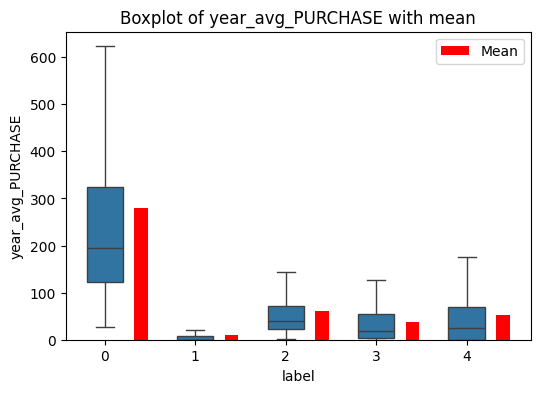

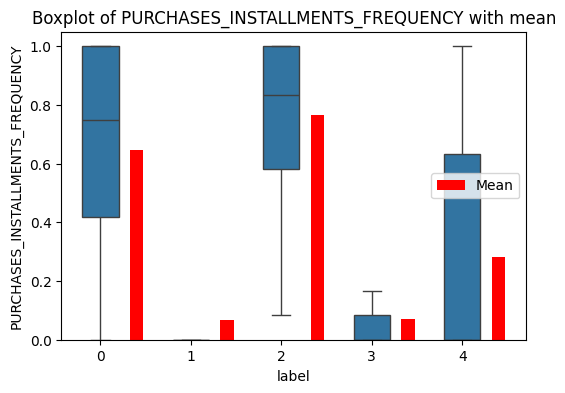

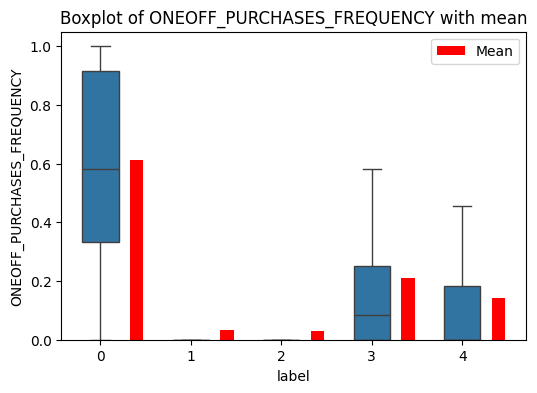

In [231]:
boxplot_by_feature(df=df, feature='CASH_ADVANCE', feature_to_group='label')
boxplot_by_feature(df=df, feature='CASH_ADVANCE_FREQUENCY', feature_to_group='label')
boxplot_by_feature(df=df, feature='CASH_ADVANCE_per_year', feature_to_group='label')

boxplot_by_feature(df=df, feature='PURCHASES_FREQUENCY', feature_to_group='label')
boxplot_by_feature(df=df, feature='year_avg_PURCHASE', feature_to_group='label')
boxplot_by_feature(df=df, feature='PURCHASES_INSTALLMENTS_FREQUENCY', feature_to_group='label')
boxplot_by_feature(df=df, feature='ONEOFF_PURCHASES_FREQUENCY', feature_to_group='label')

🔔 About the usage frequency of the different types of purchases methods we can observe:
- Cluster 1 uses less the credit service for purchasing but almost only for cash advance (significantly more than the others).
- Cluster 0 purchases with the most frequency both with one off method and installments.
- Cluster 2 is similar to cluster 0 on the purchasing frequency but uses practically only on the installments.
- Clusters 3 and 4 are hybrid having medium purchasing frequency with more tendency in one off for cluster 3 and in installments for cluster 4.

# Conclusions

🔍 **Cluster 0**: Customers with high card use [19,7%]
- High average balance, high update frequency → Users who use the card often.
- High purchases and number of transactions, especially in one-time → They spend a lot with single transactions.
- Good use of installments on purchases and also high installment payments, reliable on payments → They may not be very sensitive to interests.
- High credit limit.

📢 Marketing strategies:
- ✅ Offer cashback and loyalty rewards to incentivize card use.
- ✅ Promotions on installment purchases (zero interest, bonus on installments).
- ✅ Offer a premium card with exclusive benefits for high-spending customers (to keep their engagement high).


---


🔍 **Cluster 1**: Users with high cash advance, low purchases [21,8%]
- Low purchases, almost no lump sum or installment payments.
- Very high cash advance (and high frequency) → They often (almost only) withdraw cash from the card.
- High payments, but very low total payment percentage → Despite the low full payments percentage the ratio on minimum payments is high so they aren't insolvent customers.

📢 Marketing strategies:
- ✅ Offer installment programs to reduce their use of cash advance.
- ✅ Incentivize card use for purchases rather than withdrawals.
- ✅ Offer debt management services to improve their financial stability.


---


🔍 **Cluster 2**: Moderate users with a preference for installment payments [21,7%]
- Relatively low balance.
- Moderate purchases, more in installments than in a lump sum and a medium-high purchase frequency.
- Payments handled, with full payments percentage higher than other clusters.
- Average credit limit.

📢 Marketing strategies:
- ✅ Offer discounts and bonuses for those who use installment payment.
- ✅ Propose cards with benefits on installment payments (e.g., interest reduction).
- ✅ Incentivize card use for larger amounts, perhaps with loyalty programs.


---


🔍 **Cluster 3**: Occasional and low-use users [22,6%]
- Very low balance, low purchases and very few transactions.
- Low payments, limited credit.
- Low frequency of card use.

📢 Marketing strategies:
- ✅ Offer welcome bonuses or incentives to increase card usage.
- ✅ Create cashback programs or discounts for those who exceed a certain spending threshold.
- ✅ Offer deals on recurring services (subscriptions, bills) to build customer loyalty.


---


🔍 **Cluster 4**: Customers with balanced usage and constant payments [14,1%]
- Average balance and moderate purchases, evenly distributed between lump sum and installments.
- Regular payments and credit not too high.
- Balanced card usage.

📢 Marketing strategies:
- ✅ Incentivize credit limit increase to encourage more spending.
- ✅ Offer personalized promotions based on their purchasing patterns.
- ✅ Create loyalty plans to maintain their loyalty over the long term.
